In [34]:
import torch
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd

In [35]:
filename = '/global/cfs/cdirs/m4287/cosmology/dessn/autoscan_features.3.csv'

df = pd.read_csv(filename, skiprows=6, usecols=[0, 1], header=None, names=['ID', 'OBJECT_TYPE'])
data = dict(zip(df['ID'], df['OBJECT_TYPE']))

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
hdu = fits.open("/global/cfs/cdirs/m4287/cosmology/dessn/stamps/stamps_1/home2/SNWG/Archive/2013/Y1/20131117/485464256/diff9608733.fits")

In [41]:
!pwd

/global/u1/b/bthorne/projects


In [26]:
hdu.info()

Filename: /global/cfs/cdirs/m4287/cosmology/dessn/stamps/stamps_1/home2/SNWG/Archive/2013/Y1/20131117/485464256/diff9608733.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      46   (51, 51)   float32   


In [27]:
header = hdu[0].header
for keyword, value in header.items():
    print(f'{keyword:8s} : {value}')

SIMPLE   : True
BITPIX   : -32
NAXIS    : 2
NAXIS1   : 51
NAXIS2   : 51
EXTEND   : True
COMMENT  :   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT  :   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
EXPTIME  : 200.0
DATE-OBS : 2013-11-18T01:51:39.695221
TIME-OBS : 01:51:39.695221
MJD-OBS  : 56614.07754277
EXPNUM   : 255451
FILTER   : i DECam SDSS c0003 7835.0 1470.0
CRPIX1   : 2859.6
CRPIX2   : 3799.667
PV1_7    : -0.004429008543732
PV2_8    : 0.004111165603317
PV2_9    : -0.004599195150925
CD1_1    : -1.073542783269e-08
PV2_0    : -9.992789416838e-07
PV2_1    : 1.000507356853
PV2_2    : 4.462963928946e-05
PV2_3    : 0.0
PV2_4    : 0.02148572857372
PV2_5    : -0.001590013309706
PV2_6    : -0.0007962251228669
PV2_7    : -0.03240703441754
PV1_6    : -0.003515850199915
PV2_10   : -0.001927759163939
PV1_4    : -0.0004865700576489
PV1_3    : 0.0
PV1_2    : 0.0007126777821658
PV1_1    : 1.005716767439
PV1_0    : 0.0002577290433755
PV1_9

In [28]:
hdu[0].data.shape

(51, 51)

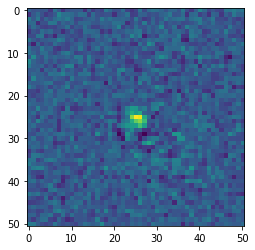

In [29]:
plt.imshow(hdu[0].data)

In [31]:
!conda install -y pandas

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pandas-1.1.5               |   py36ha9443f7_0         8.2 MB
    ------------------------------------------------------------
                                           Total:         8.2 MB

The following NEW packages will be INSTALLED:

  pandas             pkgs/main/linux-64::pandas-1.1.5-py36ha9443f7_0



pandas-1.1.5         | 8.2 MB    | #######

In [ ]:
y
